In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import os

from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from joblib import dump, load
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

## Lá para baixo em título grande "Aqui deu certo" é onde deu certo. :)

In [3]:
class MakeMiracles():
    
    def __init__(self, use_cols,dataset_list, path):
        self.use_cols = use_cols
        self.dataset_list = dataset_list
        self.path = path

    def process_name_cols(self,lista):
        for i in range(len(lista)):
            lista[i] = lista[i].replace(" ", "")
            lista[i] = lista[i].replace("_", "")
        return lista

    def cols_match(self,col):
        import re
     
        for name in self.use_cols:
            #findall = re.findall(f'[{name}]', col)
            A = re.findall("[a-zA-Z]", col)
            B = re.findall("[a-zA-Z]", name)
            if A == B:
                
                return True

        return False

    def get_cols_per_dataset(self):
        
        cols_per_dataset = {}

        for dataset in self.dataset_list:
            dataset_path = os.path.join(self.path,f'{dataset}.csv')
            
            #cols_list = self.process_name_cols(list(pd.read_csv(dataset_path, nrows=1).columns))
            cols_list = list(pd.read_csv(dataset_path, nrows=1).columns)
            
            cols_per_dataset[dataset] = []
            for col in cols_list: 
                if self.cols_match(col):
                    cols_per_dataset[dataset] += [col]

        return cols_per_dataset
    
    def get_cols_to_use(self):
        
        cols_per_dataset = self.get_cols_per_dataset()
        cols_df = pd.DataFrame(cols_per_dataset.values(), index=cols_per_dataset.keys())
        desc = cols_df.describe()
        cols_to_use = list(desc.iloc[2])
        #pd.Series(cols_per_dataset).describe()

        return cols_to_use


<h3> Loading and preparing dataset </h3>

In [31]:
fractions = {}
def init_dataset_preprocessing(dataset_list, path={'normal':'','attack':''},ddos_rows=0,normal_rows=0,ddos_sizes=None,normal_sizes=None):


    use_cols = ['ACKFlagCount',
             'InitWinbytesforward',
             'BwdInitWinBytes',
             'PacketLengthStd',
             'AveragePacketSize',
             'MinPacketLength',
             'PacketLengthMin',
             'Protocol']

    cols_on_normal_dataset = ['ACK Flag Cnt','Init Fwd Win Byts','Pkt Len Std','Pkt Size Avg','Pkt Len Min','Protocol','Label']
    
    def make_normal_dataframe(normal_rows):
        if normal_sizes:
            mm = MakeMiracles(use_cols=cols_on_normal_dataset, dataset_list=dataset_list['normal'],path=path['normal'])
        else:
            mm = MakeMiracles(use_cols=cols_on_normal_dataset, dataset_list=dataset_list['normal'],path=path['normal'])

        all_dataset_cols = mm.get_cols_per_dataset()

        normal = pd.DataFrame(columns = mm.get_cols_to_use())
        
        for dataset in dataset_list['normal']:
            usecols = all_dataset_cols[dataset]
            dataset_path = os.path.join(path['normal'],f'{dataset}.csv')
            
            dataset_size=normal_rows
            
            if normal_sizes:
                dataset_size = normal_sizes[dataset]
            
            if dataset_size < normal_rows:
                normal_rows = dataset_size
                
            frac = int(0.2*normal_rows)
            fractions[dataset]=frac
            
            loaded_dataset = pd.read_csv(dataset_path, usecols = usecols, nrows=normal_rows)
            normal = pd.concat([normal, loaded_dataset.iloc[frac:]], axis=0)
            
        return normal
        
    def make_ddos_dataframe(ddos_rows):
        
        mm = MakeMiracles(use_cols=use_cols, dataset_list=dataset_list['ddos'],path=path['attack'])
        loaded_dataset = None
        all_dataset_cols = mm.get_cols_per_dataset()

        ddos = pd.DataFrame(columns = mm.get_cols_to_use())
        
        for dataset in mm.dataset_list :
            
            usecols = all_dataset_cols[dataset]
            dataset_path = os.path.join(path['attack'],f'{dataset}.csv')
            
            dataset_size=ddos_rows
            
            if ddos_sizes:
                dataset_size = ddos_sizes[dataset]
            
            if dataset_size < ddos_rows:
                ddos_rows = dataset_size
                
            frac = int(0.2*ddos_rows)
            fractions[dataset]=frac

            if dataset == 'botnet-capture-20110815-rbot-dos.pcap_Flow':
                loaded_dataset = pd.read_csv(dataset_path, usecols=usecols, nrows=8000)#??????????
            else:
                loaded_dataset = pd.read_csv(dataset_path, usecols=usecols, nrows=ddos_rows)

            ddos = pd.concat([ddos, loaded_dataset.iloc[frac:]], axis=0)

        return ddos

    #porporcional
    normal_rows = normal_rows
    ddos_rows = ddos_rows

    ddos = make_ddos_dataframe(ddos_rows)
    normal = make_normal_dataframe(normal_rows)
    
    ddos_label = ['attack' for label in range(0,ddos.shape[0])]
    ddos = ddos.assign(Label=lambda x: ddos_label)
    
    normal_label = ['normal' for label in range(0,normal.shape[0])]
    normal = normal.assign(Label=lambda x: normal_label)
    
    print(normal.shape,ddos.shape)
    print("Normal : ",normal.columns)
    print("DDoS : ",ddos.columns)
    
    if len(ddos.columns) > 7:
        ddos.drop(['Protocol', 'Packet Length Min', 'Packet Length Std',
       'ACK Flag Count', 'Average Packet Size', 'Bwd Init Win Bytes'], axis=1, inplace=True)
        
    normal.columns = ddos.columns
    print("Normal : ",normal.shape,"DDoS : ",ddos.shape)
    print(normal.columns)
    print(ddos.columns)
    
    ddos = ddos.sample(frac = 1)
    normal = normal.sample(frac = 1)
    
    X = pd.concat([ddos, normal], axis=0)

    #preencher valores faltantes com variáveis próximas, acima ou abaixo
    X.interpolate(method='bfill', inplace=True)
    X = X.sample(frac = 1) 
    X = X.reset_index(drop=True)
    return X

In [5]:
#fazer uma lista de índices do label para poder rastrear o resultado depois
def make_label_index(X_labeled):
    list_indexes = []
    for i in X['Label'].index:
        list_indexes.append((i,X['Label'].iloc[i]))
    return list_indexes

<h3> Deleting LABEL </h3>

In [6]:
def del_labels(X):
    X.dropna(axis=0, subset=['Label'], inplace=True)
    y = X.Label
    X.drop(['Label'], axis=1, inplace=True)
    return X,y

### Change Label Names

In [7]:
def change_label_names(y):
    label_list = {'normal':0,'attack':1}
    y = pd.Series([label_list[label] for label in y])
    return y

<h3> Separar colunas com valores Objeto das com valores Numéricos </h3>

In [8]:
def split_categorical_numerical(X):
    object_cols = [ cols for cols in X.columns if X[cols].dtype == 'object']

    #print([ cols for cols in X.columns if X[cols].isnull().any()])
    numerical_cols = [ (cols, X[cols].dtype) for cols in X.columns if cols not in X[object_cols]]
    #print(len(object_cols), '\n', len(numerical_cols))
    
    return object_cols,numerical_cols

<h3> Separar os dados do Treino </h3>

In [9]:
def split_train_test(X,y):
    return train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=42)

<h1 align=center> Transformar os dados </h1>

<h3>Resolver Colunas Categóricas </h3>

In [10]:
def transform_categorical(X_before, object_cols):
    
    label_encoder = LabelEncoder()
    X_categorical = X_before.loc[:,object_cols]
    
    for col in object_cols:
        X_categorical[col] = label_encoder.fit_transform(X_before[col].astype(str))
    
    return X_categorical

<h3> Escalar os dados </h3>

In [11]:
# scale the goals from 0 to 1

def scale_numericals(numerical_cols, X_before):

    num_cols_names = list(map(lambda x: x[0], numerical_cols[:]))
    np_col = pd.DataFrame(X_before.loc[:,num_cols_names])
    sub = [np.inf, -np.inf, -0]
    np_col.replace(sub, np.float64(), inplace=True)
    scaled_X = minmax_scaling(np_col, columns=num_cols_names)
    '''
    #plot the original & scaled data together to compare
    fig, ax=plt.subplots(1,2,figsize=(15,3))
    sns.histplot(np_col, ax=ax[0])

    ax[0].set_title(num_cols_names)
    sns.histplot(scaled_X, ax=ax[1])
    ax[1].set_title(num_cols_names)
    '''
      
    return scaled_X

<h3> Unir todos novamente </h3>

In [12]:
def concat_categorical_numerical(scaled_X, categorical_X):
    return pd.concat([scaled_X, categorical_X],axis=1)

In [13]:
########## for test, if not scaled
'''X_train = pd.concat([X_train_full[num_cols_names], X_train_full_labels],axis=1)
X_valid = pd.concat([X_valid_full[num_cols_names], X_valid_full_labels],axis=1)
X_test = pd.concat([X_test[num_cols_names], X_test_labels],axis=1)'''


'X_train = pd.concat([X_train_full[num_cols_names], X_train_full_labels],axis=1)\nX_valid = pd.concat([X_valid_full[num_cols_names], X_valid_full_labels],axis=1)\nX_test = pd.concat([X_test[num_cols_names], X_test_labels],axis=1)'

## Processar os dados

<h1 align=center> Machine Learning </h1>

In [14]:
def timer(func):
    def encapsula(*args):
        import time
        startTime = time.time()
        result = func(*args)
        executionTime = (time.time() - startTime)
        return result,executionTime

    return encapsula

class ModelTest():
    
    def __init__(self,X_train,X_valid,y_train,y_valid,name,model):
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.model = model
        self.name = name
        self.results = {
            'probs':None,
            'prediction':None,
            'score':None,
            'f1score':None,
            'recall':None,
            'precision':None,
            'roc_score':None,
            'matthews_score':None,
            'cv_scores_mean':None,
            'train_time':None,
            'predict_time':None,
            'eval_time':None
        }

    def set_scores(self, score,f1,recall,prec,matt,cv_scores_mean):
        self.results['f1score'] = f1
        self.results['recall'] = recall
        self.results['precision'] = prec
        self.results['score'] = score
        self.results['matthews_score'] = matt
        self.results['cv_scores_mean'] = cv_scores_mean
        
    def set_model(self,name,model):
        self.model = model
        self.name = name
        
    def set_trained_model(self,prediction,probs):
        self.results['probs'] = probs
        self.results['prediction'] = prediction
        
    @timer
    def train_model(self):
        try:
            self.model.fit(self.X_train, self.y_train)
        except Exception as e:
            print(e)
            print("Não foi possível executar")
        return self.model
    
    #https://scikit-learn.org/stable/modules/model_persistence.html
    def save_model_state(self,save_model=True,save_results=True,local=""):
        if save_model==True: dump(self.model, f'{local}/{self.name}_model.joblib')
        if save_results==True: dump(self.results, f'{local}/{self.name}_results_dict.joblib')
        
    def load_model_state(self,model_name):
        model = load(f'temp_jobs/{model_name}_model.joblib')
        results = load(f'temp_jobs/{model_name}_results_dict.joblib')
        
        self.set_model(model_name,model)
        self.set_trained_model(results['prediction'],results['probs'])

        return model,results
    
    @timer
    def make_predictions(self):
        Prediction = None
        lr_probs = None
        try:
            Prediction = self.model.predict(self.X_valid)
            lr_probs = self.model.predict_proba(self.X_valid)
        except Exception as e:
            print("Não foi possível executar")
            print(e)
        #return Prediction, lr_probs
        self.set_trained_model(Prediction,lr_probs)
        
        return Prediction, lr_probs
    
    @timer
    def evaluate_model(self,model_blank=None):
        score = self.model.score(self.X_valid, self.y_valid)      
        clf = self.model
        Prediction = self.results['prediction']
        f1 = f1_score(self.y_valid, Prediction, average='binary')
        recall = recall_score(self.y_valid, Prediction, average='binary')
        cv_scores = None
        cv_scores_mean = None
        try:
            #cv_scores = cross_val_score(clf, transform_custom(X), y, cv=5)
            #cv_scores_mean = (cv_scores.mean(), cv_scores.std() * 2)
            self.plot_curves_CV(model_blank)
            print()
        except Exception as e:
            print("Não foi possível realizar o cross-validation")
            print(e)
        matt_corr = matthews_corrcoef(self.y_valid, Prediction)
        self.set_scores(score=score,prec=score,f1=f1,recall=recall,matt=matt_corr,cv_scores_mean=cv_scores_mean)
        
    def plot_roc_curve(self):
        
        model = self.model
        name = self.name
        # generate a no skill prediction (majority class)
        ns_probs = [0 for _ in range(len(self.y_valid))]
        
        # keep probabilities for the positive outcome only
        lr_probs = self.results['probs'][:,1]
        # calculate scores
        ns_auc = roc_auc_score(self.y_valid, ns_probs)
        lr_auc = roc_auc_score(self.y_valid, lr_probs)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print(f'{name} ROC AUC=%.3f' % (lr_auc))
        self.results['roc_score'] = lr_auc
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(self.y_valid, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(self.y_valid, lr_probs)
        # plot the roc curve for the model

        pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label=name)
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()

    def plot_precision_recall_curve(self):
        average_precision = average_precision_score(self.y_valid, self.results['prediction'])

        print('Average precision-recall score: {0:0.2f}'.format(
              average_precision)) 
        
        disp = plot_precision_recall_curve(self.model, self.X_valid, self.y_valid)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                           'AP={0:0.2f}'.format(average_precision))
        pyplot.show()
        
    def plot_curves_CV(self,model_blank):
        cv = StratifiedKFold(n_splits=5)
        classifier = model_blank

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X, y)):
            _X_train = X.iloc[train].copy()
            _X_test = X.iloc[test].copy()
            _y_train = y.iloc[train].copy()
            _y_test = y.iloc[test].copy()
            # i = KFOLD
            _X_train = transform_custom(_X_train).copy()
            _X_test = transform_custom(_X_test).copy()

            classifier.fit(_X_train, _y_train)
            viz = plot_roc_curve(classifier, _X_test, _y_test,
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title="Receiver operating characteristic example")
        ax.legend(loc="lower right")
        plt.show()
        
    def plot_learning_curve(self,estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
        
        if axes is None:
            _, axes = plt.subplots(1, 3, figsize=(20, 5))

        axes[0].set_title(title)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
        axes[0].set_xlabel("Training examples")
        axes[0].set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
        axes[0].grid()
        axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes[0].legend(loc="best")

        # Plot n_samples vs fit_times
        axes[1].grid()
        axes[1].plot(train_sizes, fit_times_mean, 'o-')
        axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                             fit_times_mean + fit_times_std, alpha=0.1)
        axes[1].set_xlabel("Training examples")
        axes[1].set_ylabel("fit_times")
        axes[1].set_title("Scalability of the model")

        # Plot fit_time vs score
        axes[2].grid()
        axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
        axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1)
        axes[2].set_xlabel("fit_times")
        axes[2].set_ylabel("Score")
        axes[2].set_title("Performance of the model")

        return plt

    def plot_learning(self,model_blank):

        fig, axes = plt.subplots(3, 2, figsize=(10, 15))

        title = f"Learning Curves ( {self.name} )"
        # Cross validation with 100 iterations to get smoother mean test and train
        # score curves, each time with 20% data randomly selected as a validation set.
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

        estimator = model_blank
        
        self.plot_learning_curve(estimator, title, X.copy(), y.copy(), axes=axes[:, 0], ylim=(0.7, 1.01),
                            cv=cv, n_jobs=4)

        plt.show()

    def show_predictions(self):
    
        Prediction = self.results['prediction']       
        count_acerto = 0
        total_ataques = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido!=0])
        total_normal = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido==0])
        
        acertou_ataques = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido!=0 and pred!=0])
        
        acertou_normal = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido==0 and pred==0])

        total_falso_positivo = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido==0 and pred!=0])
        total_falso_negativo = len([1 for pred,valido in zip(Prediction,self.y_valid) if valido!=0 and pred==0])
        
        precision = (acertou_ataques+acertou_normal) / (total_ataques+total_normal)
        recall = acertou_ataques/total_ataques
        f1score = 2* precision * recall/ (precision + recall)
            
        print(f"Total de ataques detectados (TP): {acertou_ataques} de um total de : {total_ataques} de ataques.\n")
        print(f"Resultando em {recall*100}% de acerto em detectar ataques (positivos). (Recall)")
        print()
        print(f"Total de Normais detectados (TN): {acertou_normal} de um total de : {total_normal} de Normais.\n")
        print(f"Resultando em {(acertou_normal/total_normal)*100}% de acerto em detectar Normais.")
        print()
        print(f"Total de Falsos Positivos (normais considerados ataques) (FP): {total_falso_positivo}")
        print(f"Total de Falsos Negativos (ataques considerados normais) (FN): {total_falso_negativo}")
        print()
        print(f"Levando a uma porcentagem de acerto geral (Acurácia) de {precision*100 }")
        print(f'E um F1-score de {f1score*100}%')
        print()
        print("\nAbaixo, análise usando os módulos do Python\n")
        print()
        print(f"\nScore : {self.results['score']}")
        #print("Cross-val acc: %0.2f (+/- %0.2f)" % self.results['cv_scores_mean'])
        print(f"\nF1-Score: {self.results['f1score']} \nRecall: {self.results['recall']}")
        print(f"\nROC AUC: {self.results['roc_score']}")
        print(f"Matthews Correlation Coefficient : {self.results['matthews_score']}")
        print("Confusion Matrix\n", confusion_matrix(self.y_valid, Prediction))
        print('Classification Report\n',classification_report(self.y_valid, Prediction))
        print()

#### Evatuate model: https://scikit-learn.org/stable/getting_started.html
#### Cross-Validation: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
#### Salvar modelo: https://scikit-learn.org/stable/modules/model_persistence.html
#### Ploting curves: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [15]:
def skip(func):
    def encapsula(*args):
        print(f'{func.__name__}{args} skipped')
        pass
    return encapsula
    
def start_model(name):
    #TO SAVE
    model_obj = ModelTest(X_train,X_valid,y_train,y_valid,name,classifiers[name])
    _,train_time = model_obj.train_model()
    [_,_], predict_time = model_obj.make_predictions()
    
    return model_obj,train_time,predict_time

@skip
def load_model(name):
    #TO LOAD
    model_obj = ModelTest(X_train,X_valid,y_train,y_valid,name,classifiers[name])
    model_obj.load_model_state(name) #a ideia é carregar o modelo sem precisar treinar o diacho denovo.

    return model_obj

def test_model(model_obj,save_model,save_results,model_blank=None,local=""):
    model_obj.plot_precision_recall_curve()
    model_obj.plot_roc_curve()
    eval_time = model_obj.evaluate_model(model_blank)
    model_obj.save_model_state(save_model=save_model,save_results=save_results,local=local)
    #model_obj.plot_learning(model_blank)
    model_obj.show_predictions()
    return eval_time

In [36]:
classifiers = {
    #'Decision_Tree':DecisionTreeClassifier(max_depth=8),
    #'Gauss_NB':GaussianNB(),
    #'Logistic_Regression':LogisticRegression(C=10000,max_iter=500),
    #'AdaBoost':AdaBoostClassifier(),
    #'Random_Forest':RandomForestClassifier(max_depth=8, n_estimators=100,random_state=1),
    #'XGB_Classifier':xgb.XGBClassifier(objective="binary:logistic", random_state=42),
    #'Multi_Layer_Perceptron':MLPClassifier(alpha=0.001, max_iter=1000),#antes alpha=1
    'K_Nearest_Neighbors': KNeighborsClassifier(3),
    #'Gaussian_Process':GaussianProcessClassifier(1.0 * RBF(1.0)),
    #'Quadratic_Discriminant_Analysis':QuadraticDiscriminantAnalysis(),
    #'Support_Vector_Classifier_Kernel':SVC(kernel="linear", C=0.025,probability=True),
    #'Support_Vector_Classifier':SVC(gamma=2, C=1, probability=True)
}

In [17]:
def transform_custom(X_test):
    object_cols,numerical_cols = split_categorical_numerical(X_test)

    X_test_categorical = transform_categorical(X_test,object_cols)

    scaled_X_test = scale_numericals(numerical_cols, X_test)

    X_test = concat_categorical_numerical(scaled_X_test,X_test_categorical)
    
    return X_test

In [32]:
def transform():
    object_cols,numerical_cols = split_categorical_numerical(X)
    X_train_full, X_valid_full, y_train, y_valid = split_train_test(X,y)
    
    X_train_full_labels = transform_categorical(X_train_full,object_cols)
    X_valid_full_labels = transform_categorical(X_valid_full,object_cols)
    scaled_X_train = scale_numericals(numerical_cols, X_train_full)
    scaled_X_valid = scale_numericals(numerical_cols, X_valid_full)
    X_train = concat_categorical_numerical(scaled_X_train,X_train_full_labels)
    X_valid = concat_categorical_numerical(scaled_X_valid,X_valid_full_labels)
    
    return X_train,X_valid,y_train, y_valid

##### CIC 2019 #########

ddos_cic_full = ['LDAP_attack','MSSQL_attack','Portmap_attack','Syn_attack','UDP_attack',
                 'UDPLag_attack','DrDoS_DNS_attack','DrDoS_LDAP_attack','DrDoS_MSSQL_attack',
                 'DrDoS_NetBIOS_attack','DrDoS_NTP_attack','DrDoS_SNMP_attack','DrDoS_SSDP_attack',
                 'DrDoS_UDP_attack','Syn1_attack']
normal_cic_full = ['LDAP_normal','MSSQL_normal','Portmap_normal','Syn_normal','UDP_normal',
                 'UDPLag_normal','DrDoS_DNS_normal','DrDoS_LDAP_normal','DrDoS_MSSQL_normal',
                 'DrDoS_NetBIOS_normal','DrDoS_NTP_normal','DrDoS_SNMP_normal','DrDoS_SSDP_normal',
                 'DrDoS_UDP_normal','Syn1_normal']
ddos_cic_part = ['Syn_attack','DrDoS_UDP_attack','Syn1_attack','UDP_attack','UDPLag_attack']

ddos_sizes = {'LDAP_attack': 2108110, 'MSSQL_attack': 5772992, 'Portmap_attack': 186960, 'Syn_attack': 499838, 'UDP_attack': 3779072, 'UDPLag_attack': 366900, 'DrDoS_DNS_attack': 5071011, 'DrDoS_LDAP_attack': 2179930, 'DrDoS_MSSQL_attack': 4522492, 'DrDoS_NetBIOS_attack': 4093279, 'DrDoS_NTP_attack': 1202642, 'DrDoS_SNMP_attack': 5159870, 'DrDoS_SSDP_attack': 2610611, 'DrDoS_UDP_attack': 3134645, 'Syn1_attack': 4284751}
normal_sizes = {'LDAP_normal': 5124, 'MSSQL_normal': 2794, 'Portmap_normal': 4734, 'Syn_normal': 392, 'UDP_normal': 3134, 'UDPLag_normal': 3705, 'DrDoS_DNS_normal': 3402, 'DrDoS_LDAP_normal': 1612, 'DrDoS_MSSQL_normal': 2006, 'DrDoS_NetBIOS_normal': 1707, 'DrDoS_NTP_normal': 14365, 'DrDoS_SNMP_normal': 1507, 'DrDoS_SSDP_normal': 763, 'DrDoS_UDP_normal': 2157, 'Syn1_normal': 35790}

###### IOT 23 ##############

ddos_iot23 = [f'Parte-{num}-final_dataset' for num in range(0,9)]
#ddos_iot23 = ['Parte-1-final_dataset','Parte-2-final_dataset','Parte-3-final_dataset','Parte-4-final_dataset']

normal_iot23 = [f'Parte-{num}-final_dataset' for num in range(11,18)]
#normal_iot23 = ['Parte-17-final_dataset','Parte-18-final_dataset','Parte-19-final_dataset','Parte-20-final_dataset']

###### GERAL + PHELIPE  ##########

ddos_phelipe = ['floodAttackPackets.pcap_Flow','filePacketsAttack.pcap_Flow']

ddos_other = ['SAT-01-12-2018_0750_Flow']
ddos_mix = ['ddostrace.20070804_141436.pcap_Flow','botnet-capture-20110815-rbot-dos.pcap_Flow']

##########################

ddos_file = ddos_cic_full
normal_file = normal_iot23

ddos_path = 'datasets/separate/'
normal_path = 'datasets/partes/'

dataset_list = {
        'normal':normal_file,
        'ddos':ddos_file
        }
path = {'normal': normal_path,
        'attack': ddos_path
       }
ddos_rows = int(1000000/len(ddos_file))
normal_rows = int(500000/len(normal_file))
print(ddos_rows,normal_rows)

X = init_dataset_preprocessing(dataset_list, path,ddos_rows=ddos_rows,
                               normal_rows=normal_rows, ddos_sizes=ddos_sizes,normal_sizes=None)
X,y = del_labels(X)

y = change_label_names(y)
X_train,X_valid,y_train, y_valid = transform()
#apenas teste... tlvz remover
'''X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)'''
dump(fractions, 'dataset_fractions.joblib')
X.shape

66666 71428
(400001, 7) (799995, 7)
Normal :  Index(['Protocol', 'Pkt Len Min', 'Pkt Len Std', 'ACK Flag Cnt',
       'Pkt Size Avg', 'Init Fwd Win Byts', 'Label'],
      dtype='object')
DDoS :  Index([' Protocol', ' Min Packet Length', ' Packet Length Std',
       ' ACK Flag Count', ' Average Packet Size', 'Init_Win_bytes_forward',
       'Label'],
      dtype='object')
Normal :  (400001, 7) DDoS :  (799995, 7)
Index([' Protocol', ' Min Packet Length', ' Packet Length Std',
       ' ACK Flag Count', ' Average Packet Size', 'Init_Win_bytes_forward',
       'Label'],
      dtype='object')
Index([' Protocol', ' Min Packet Length', ' Packet Length Std',
       ' ACK Flag Count', ' Average Packet Size', 'Init_Win_bytes_forward',
       'Label'],
      dtype='object')


(1199996, 6)

In [ ]:
#para pegar o tamanho dos datasets e ganhar tempo
'''ddos_sizes = {}
for dataset in ddos_cic_full:
    usecols = pd.read_csv(f'datasets/separate/{dataset}.csv', nrows=1).columns
    sample_dataset = pd.read_csv(f'datasets/separate/{dataset}.csv', usecols=[usecols[-1]])
    dataset_size = sample_dataset.shape[0]
    ddos_sizes[dataset] = dataset_size
    del sample_dataset
    
normal_sizes = {}
for dataset in normal_cic_full:
    usecols = pd.read_csv(f'datasets/separate/{dataset}.csv', nrows=1).columns
    sample_dataset = pd.read_csv(f'datasets/separate/{dataset}.csv', usecols=[usecols[-1]])
    dataset_size = sample_dataset.shape[0]
    normal_sizes[dataset] = dataset_size
    del sample_dataset'''

In [33]:
fractions

{'LDAP_attack': 13333,
 'MSSQL_attack': 13333,
 'Portmap_attack': 13333,
 'Syn_attack': 13333,
 'UDP_attack': 13333,
 'UDPLag_attack': 13333,
 'DrDoS_DNS_attack': 13333,
 'DrDoS_LDAP_attack': 13333,
 'DrDoS_MSSQL_attack': 13333,
 'DrDoS_NetBIOS_attack': 13333,
 'DrDoS_NTP_attack': 13333,
 'DrDoS_SNMP_attack': 13333,
 'DrDoS_SSDP_attack': 13333,
 'DrDoS_UDP_attack': 13333,
 'Syn1_attack': 13333,
 'Parte-11-final_dataset': 14285,
 'Parte-12-final_dataset': 14285,
 'Parte-13-final_dataset': 14285,
 'Parte-14-final_dataset': 14285,
 'Parte-15-final_dataset': 14285,
 'Parte-16-final_dataset': 14285,
 'Parte-17-final_dataset': 14285}

## Precisa ver o LEAK do ploting learning curves

Datasets utilizados

Arquivos DDoS : ['LDAP_attack', 'MSSQL_attack', 'Portmap_attack', 'Syn_attack', 'UDP_attack', 'UDPLag_attack', 'DrDoS_DNS_attack', 'DrDoS_LDAP_attack', 'DrDoS_MSSQL_attack', 'DrDoS_NetBIOS_attack', 'DrDoS_NTP_attack', 'DrDoS_SNMP_attack', 'DrDoS_SSDP_attack', 'DrDoS_UDP_attack', 'Syn1_attack']
Arquivos Normal : ['Parte-11-final_dataset', 'Parte-12-final_dataset', 'Parte-13-final_dataset', 'Parte-14-final_dataset', 'Parte-15-final_dataset', 'Parte-16-final_dataset', 'Parte-17-final_dataset']

_______________________________________

Classificador :  Decision_Tree
Tempo total para treinar o modelo :  2.0299620628356934
Tempo total predições com o modelo :  0.12499642372131348
Average precision-recall score: 0.99


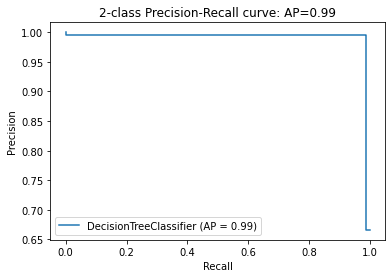

No Skill: ROC AUC=0.500
Decision_Tree ROC AUC=0.984


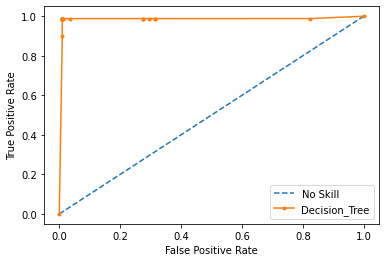

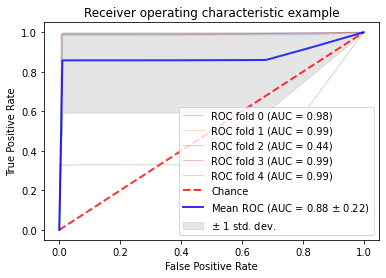


Total de ataques detectados (TP): 315823 de um total de : 319747 de ataques.

Resultando em 98.77277972897322% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 158656 de um total de : 160252 de Normais.

Resultando em 99.00406859196765% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 1596
Total de Falsos Negativos (ataques considerados normais) (FN): 3924

Levando a uma porcentagem de acerto geral (Acurácia) de 98.84999760416167
E um F1-score de 98.81137358075514%


Abaixo, análise usando os módulos do Python



Score : 0.9884999760416168

F1-Score: 0.9913366375481428 
Recall: 0.9877277972897321

ROC AUC: 0.9839275949623838
Matthews Correlation Coefficient : 0.9742961437303856
Confusion Matrix
 [[158656   1596]
 [  3924 315823]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    160252
           1       0.99      0.99      0.99

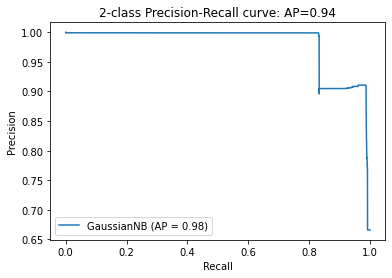

No Skill: ROC AUC=0.500
Gauss_NB ROC AUC=0.961


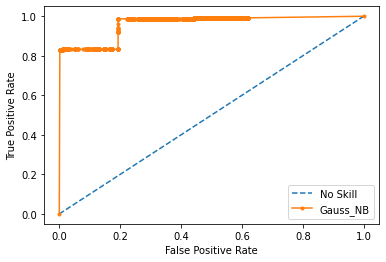

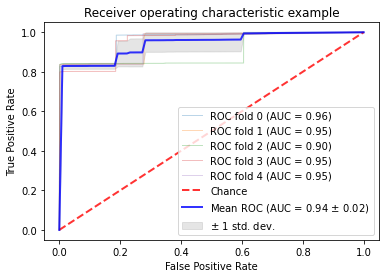


Total de ataques detectados (TP): 265911 de um total de : 319747 de ataques.

Resultando em 83.16293819801281% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 158778 de um total de : 160252 de Normais.

Resultando em 99.08019868706786% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 1474
Total de Falsos Negativos (ataques considerados normais) (FN): 53836

Levando a uma porcentagem de acerto geral (Acurácia) de 88.47705932720693
E um F1-score de 85.73773389491318%


Abaixo, análise usando os módulos do Python



Score : 0.8847705932720693

F1-Score: 0.9057963115619656 
Recall: 0.831629381980128

ROC AUC: 0.9606403572234476
Matthews Correlation Coefficient : 0.780800685429706
Confusion Matrix
 [[158778   1474]
 [ 53836 265911]]
Classification Report
               precision    recall  f1-score   support

           0       0.75      0.99      0.85    160252
           1       0.99      0.83      0.91 

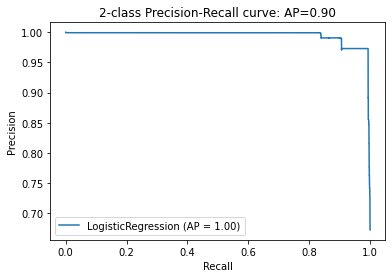

No Skill: ROC AUC=0.500
Logistic_Regression ROC AUC=0.990


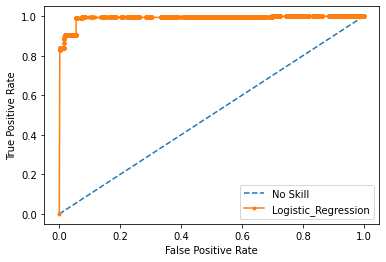

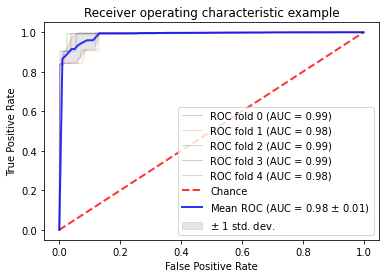


Total de ataques detectados (TP): 317741 de um total de : 319747 de ataques.

Resultando em 99.3726289847911% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 127101 de um total de : 160252 de Normais.

Resultando em 79.31320669944837% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 33151
Total de Falsos Negativos (ataques considerados normais) (FN): 2006

Levando a uma porcentagem de acerto geral (Acurácia) de 92.67560974085363
E um F1-score de 95.90735165109724%


Abaixo, análise usando os módulos do Python



Score : 0.9267560974085363

F1-Score: 0.9475768632602638 
Recall: 0.993726289847911

ROC AUC: 0.9903228832526234
Matthews Correlation Coefficient : 0.8368351267554514
Confusion Matrix
 [[127101  33151]
 [  2006 317741]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.79      0.88    160252
           1       0.91      0.99      0.95 

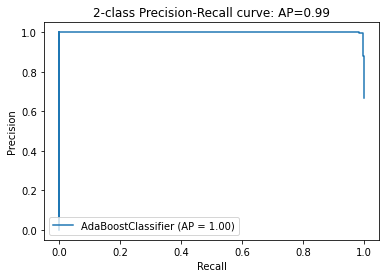

No Skill: ROC AUC=0.500
AdaBoost ROC AUC=0.999


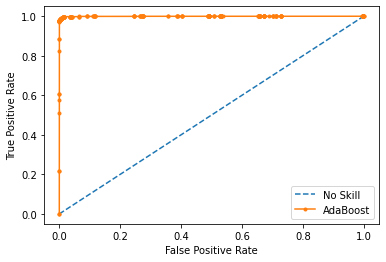

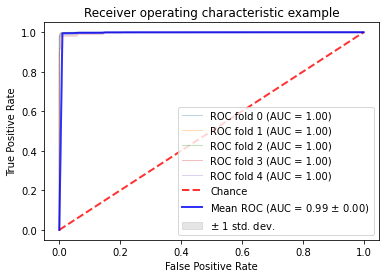


Total de ataques detectados (TP): 316381 de um total de : 319747 de ataques.

Resultando em 98.94729270329354% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 159113 de um total de : 160252 de Normais.

Resultando em 99.28924444000698% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 1139
Total de Falsos Negativos (ataques considerados normais) (FN): 3366

Levando a uma porcentagem de acerto geral (Acurácia) de 99.06145637803412
E um F1-score de 99.00434162963164%


Abaixo, análise usando os módulos do Python



Score : 0.9906145637803412

F1-Score: 0.9929307495916155 
Recall: 0.9894729270329354

ROC AUC: 0.9994648625000735
Matthews Correlation Coefficient : 0.9790251575726686
Confusion Matrix
 [[159113   1139]
 [  3366 316381]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    160252
           1       1.00      0.99      0.99

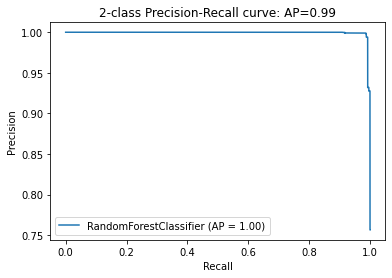

No Skill: ROC AUC=0.500
Random_Forest ROC AUC=0.999


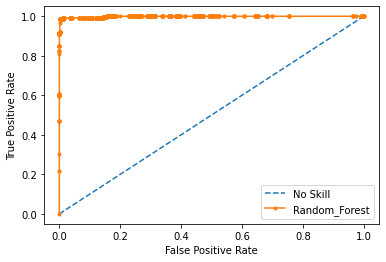

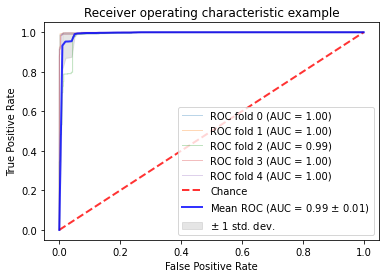


Total de ataques detectados (TP): 315685 de um total de : 319747 de ataques.

Resultando em 98.72962060629185% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 159762 de um total de : 160252 de Normais.

Resultando em 99.69423158525322% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 490
Total de Falsos Negativos (ataques considerados normais) (FN): 4062

Levando a uma porcentagem de acerto geral (Acurácia) de 99.05166469096811
E um F1-score de 98.89038045902919%


Abaixo, análise usando os módulos do Python



Score : 0.9905166469096811

F1-Score: 0.9928418894141104 
Recall: 0.9872962060629185

ROC AUC: 0.9986120907802096
Matthews Correlation Coefficient : 0.9789326210014093
Confusion Matrix
 [[159762    490]
 [  4062 315685]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    160252
           1       1.00      0.99      0.99 

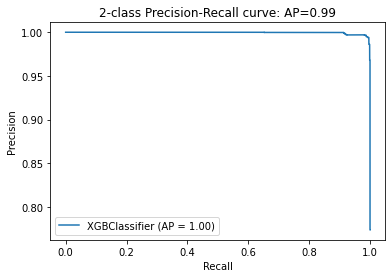

No Skill: ROC AUC=0.500
XGB_Classifier ROC AUC=0.999


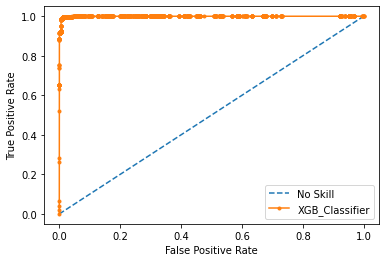

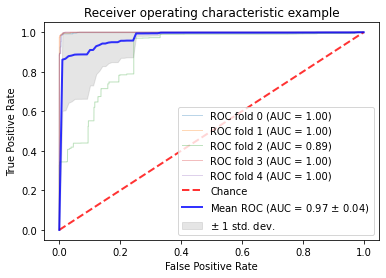


Total de ataques detectados (TP): 315773 de um total de : 319747 de ataques.

Resultando em 98.75714236568287% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 158685 de um total de : 160252 de Normais.

Resultando em 99.02216508998328% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 1567
Total de Falsos Negativos (ataques considerados normais) (FN): 3974

Levando a uma porcentagem de acerto geral (Acurácia) de 98.84562259504708
E um F1-score de 98.80136267104959%


Abaixo, análise usando os módulos do Python



Score : 0.9884562259504708

F1-Score: 0.9913026007436976 
Recall: 0.9875714236568287

ROC AUC: 0.9992346125519896
Matthews Correlation Coefficient : 0.9742052544645526
Confusion Matrix
 [[158685   1567]
 [  3974 315773]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    160252
           1       1.00      0.99      0.99

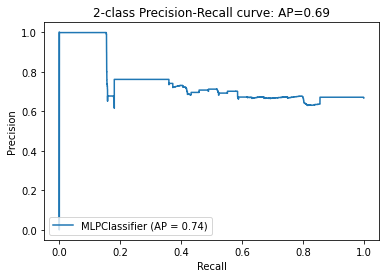

No Skill: ROC AUC=0.500
Multi_Layer_Perceptron ROC AUC=0.526


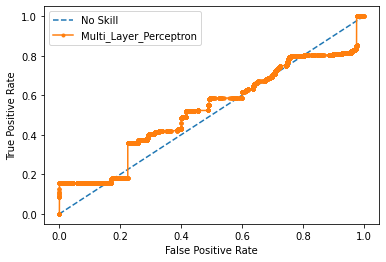

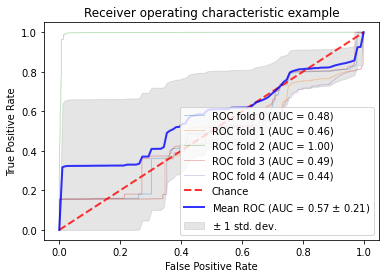


Total de ataques detectados (TP): 49896 de um total de : 319747 de ataques.

Resultando em 15.604837574707503% de acerto em detectar ataques (positivos). (Recall)

Total de Normais detectados (TN): 147597 de um total de : 160252 de Normais.

Resultando em 92.10306267628485% de acerto em detectar Normais.

Total de Falsos Positivos (normais considerados ataques) (FP): 12655
Total de Falsos Negativos (ataques considerados normais) (FN): 269851

Levando a uma porcentagem de acerto geral (Acurácia) de 41.144460717626494
E um F1-score de 22.627685131543792%


Abaixo, análise usando os módulos do Python



Score : 0.41144460717626496

F1-Score: 0.2610319698245871 
Recall: 0.15604837574707503

ROC AUC: 0.5255666941912389
Matthews Correlation Coefficient : 0.10797488079375793
Confusion Matrix
 [[147597  12655]
 [269851  49896]]
Classification Report
               precision    recall  f1-score   support

           0       0.35      0.92      0.51    160252
           1       0.80      0.16  

['all_results_dict.joblib']

In [35]:
all_results = {}
print("Datasets utilizados\n")
print(f"Arquivos DDoS : {ddos_file}")
print(f"Arquivos Normal : {normal_file}")
local = 'temp_jobs/'

for name,clf in zip(classifiers.keys(),classifiers.values()):
    print("\n_______________________________________\n") 
    print("Classificador : ", name)
    model_obj,train_time,predict_time,eval_time = None,None,None,None
    try:
        model_obj,train_time,predict_time = start_model(name)
        print("Tempo total para treinar o modelo : ",train_time)
        print("Tempo total predições com o modelo : ",predict_time)
    except Exception as e:
        print('Não foi possível iniciar este modelo')
        print(e)
    try:
        eval_time = test_model(model_obj,save_model=True,save_results=True,model_blank=clf,local=local)
        print("Tempo total para testar o modelo : ",eval_time)
    except Exception as e:
        print('Não foi possível testar este modelo')
        print(e)
    print("\n_______________________________________\n")
    
    try:
        model_obj.results['train_time'] = train_time
        model_obj.results['predict_time'] = predict_time
        model_obj.results['eval_time'] = eval_time
        all_results[name] = model_obj.results
    except:
        print("Não foi possível salvar os resultados")

dump(all_results, 'all_results_dict.joblib')
